In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

/home/nihang/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##transform.ToTensor: convert image to numbers
##transform.Normalize: normalize the tensor with mean and std.
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# download MNIST dataset
trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28]) torch.Size([64])


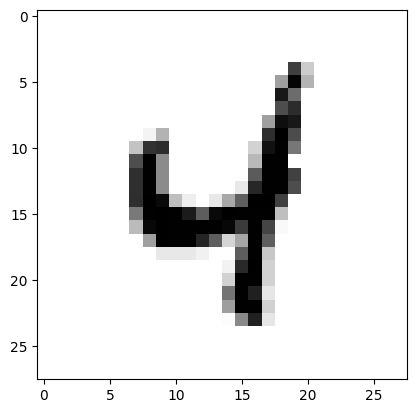

In [4]:
## 
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

## show an image
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [5]:
# ## display more images
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [6]:
## build the neural network with two hidden layers
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [7]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [9]:
## training process
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()

train_list = []
valid_list = []

min_loss = np.inf
epochs = 50
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    #else:
    #    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        
    ## valid each epoch
    correct_count, all_count = 0, 0
    valid_loss = 0
    with torch.no_grad():
        for images,labels in valloader:
            img = images.view(images.shape[0], -1)
            output = model(img)
            # print(output.shape)
            loss = criterion(output, labels)
            valid_loss += loss
            for i in range(len(labels)):
                img = images[i].view(1, 784)
                with torch.no_grad():
                    logps = model(img)
                ps = torch.exp(logps)
                probab = list(ps.numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.numpy()[i]
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1
    
    
    tmp_train_loss = running_loss/len(trainloader)
    tmp_valid_loss = valid_loss/len(valloader)
    
    train_list.append(tmp_train_loss)
    valid_list.append(tmp_valid_loss)
    
    if min_loss > tmp_valid_loss:
        bst_model = model
    print("Epoch {} - Training loss: {}, Valid loss: {}, valid accuracy: {}".format(e, tmp_train_loss, tmp_valid_loss, correct_count/all_count))
    # print("Number Of Images Tested =", all_count)
    #print("Valid Model Accuracy =", (correct_count/all_count))
    
    
print("Training Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.2824671301148784, Valid loss: 0.22361041605472565, valid accuracy: 0.9356
Epoch 1 - Training loss: 0.21677226399276048, Valid loss: 0.1829182207584381, valid accuracy: 0.9432
Epoch 2 - Training loss: 0.17406783690815097, Valid loss: 0.16180270910263062, valid accuracy: 0.952
Epoch 3 - Training loss: 0.14617622312285436, Valid loss: 0.13468429446220398, valid accuracy: 0.9588
Epoch 4 - Training loss: 0.12570883839258126, Valid loss: 0.12193785607814789, valid accuracy: 0.963
Epoch 5 - Training loss: 0.11066819194839327, Valid loss: 0.11157020181417465, valid accuracy: 0.9666
Epoch 6 - Training loss: 0.09836611926639036, Valid loss: 0.11563429981470108, valid accuracy: 0.9661
Epoch 7 - Training loss: 0.08820285961262263, Valid loss: 0.09655115753412247, valid accuracy: 0.9708
Epoch 8 - Training loss: 0.08040303190244731, Valid loss: 0.09677457064390182, valid accuracy: 0.9682
Epoch 9 - Training loss: 0.07311928552736256, Valid loss: 0.09315962344408035, valid a

In [10]:
## save best model
torch.save(bst_model, './my_mnist_model.pt') 

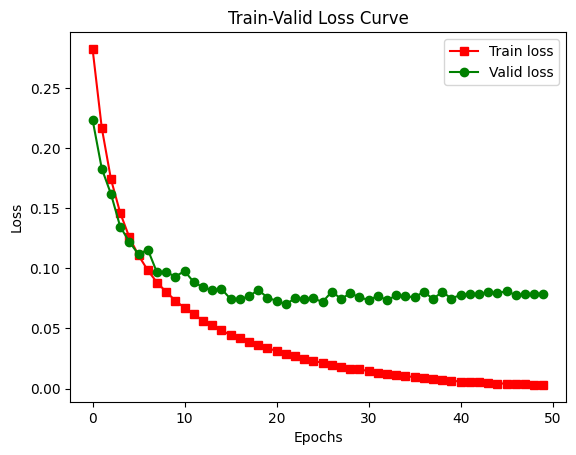

In [15]:
## plot loss cruve
import matplotlib.pyplot as plt

idx_list = list(range(len(valid_list)))

#fig = plt.figure()
plt.plot(idx_list,train_list,'s-',color = 'r',label="Train loss")  # train curve
plt.plot(idx_list,valid_list,'o-',color = 'g',label="Valid loss")  # validation curve
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend() 
plt.title("Train-Valid Loss Curve")
plt.savefig("Q1_loss_curve")
plt.show()


In [16]:
## use the same architecture, but increase the number of neurons in the hidden layers.


## build the neural network with one hidden layer
input_size = 784
hidden_sizes = [256, 128]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

## training process
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()

train_list = []
valid_list = []

min_loss = np.inf
epochs = 50
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    #else:
    #    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        
    ## valid each epoch
    correct_count, all_count = 0, 0
    valid_loss = 0
    with torch.no_grad():
        for images,labels in valloader:
            img = images.view(images.shape[0], -1)
            output = model(img)
            # print(output.shape)
            loss = criterion(output, labels)
            valid_loss += loss
            for i in range(len(labels)):
                img = images[i].view(1, 784)
                with torch.no_grad():
                    logps = model(img)
                ps = torch.exp(logps)
                probab = list(ps.numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels.numpy()[i]
                if(true_label == pred_label):
                    correct_count += 1
                all_count += 1
    
    
    tmp_train_loss = running_loss/len(trainloader)
    tmp_valid_loss = valid_loss/len(valloader)
    
    train_list.append(tmp_train_loss)
    valid_list.append(tmp_valid_loss)
    
    if min_loss > tmp_valid_loss:
        bst_model = model
    print("Epoch {} - Training loss: {}, Valid loss: {}, valid accuracy: {}".format(e, tmp_train_loss, tmp_valid_loss, correct_count/all_count))
    # print("Number Of Images Tested =", all_count)
    #print("Valid Model Accuracy =", (correct_count/all_count))
    
    
print("Training Time (in minutes) =",(time()-time0)/60)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 0.6085343710395065, Valid loss: 0.302420973777771, valid accuracy: 0.9102
Epoch 1 - Training loss: 0.27243654767095027, Valid loss: 0.22397109866142273, valid accuracy: 0.9351
Epoch 2 - Training loss: 0.2100204850938211, Valid loss: 0.17923890054225922, valid accuracy: 0.947
Epoch 3 - Training loss: 0.16712841436441647, Valid loss: 0.15027521550655365, valid accuracy: 0.9542
Epoch 4 - Training loss: 0.13784878640207274, Valid loss: 0.12717264890670776, valid accuracy: 0.9631
Epoch 5 - Training loss: 0.11811551319034115, Valid loss: 0.11522170156240463, valid accuracy: 0.9657
Epoch 6 - Training loss: 0.10164314809578981, Valid loss: 0.11276401579380035, valid accuracy: 0.9651
Epoch 7 - Training loss: 0.08821811775035505,

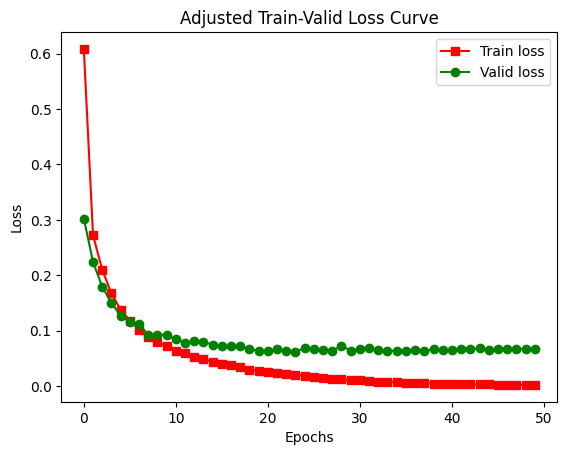

In [18]:
## plot loss cruve
import matplotlib.pyplot as plt

idx_list = list(range(len(valid_list)))

#fig = plt.figure()
plt.plot(idx_list,train_list,'s-',color = 'r',label="Train loss")  # train curve
plt.plot(idx_list,valid_list,'o-',color = 'g',label="Valid loss")  # validation curve
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend() 
plt.title("Adjusted Train-Valid Loss Curve")
plt.savefig("adjusted_Q1_loss_curve")
plt.show()
